In [1]:
import os 
import torch 
import numpy as np 
import networkx as nx 

from matplotlib import pyplot as plt 

from matplotlib.patches import FancyArrowPatch
from networkx.drawing.nx_pylab import draw_networkx_nodes, draw_networkx_labels

from dagma import utils 
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

In [2]:
project_dir = "../../"

os.chdir(project_dir)

In [3]:
from data_generation.simulation_data import InterventionDataset

from models.helper.functions import gumbelSoftMLP, gnet_z
from models.nodags.resblock import iResBlock
from models.dccd.implicitblock import imBlock
from models.helper.layers.mlpLipschitz import linearLipschitz
from models.dccd.trainer_dccd import DCCDTrainer

from utils.plotting import draw_curved_edges
from utils.graph_transformations import *
from utils.error_metrics import *

## Load data

In [4]:
data_dir = "datasets/sachs"

In [5]:
intervention_sets = [[None]]

datasets = list()
for i in range(len(intervention_sets)):
    dataset = np.load(os.path.join(data_dir, f"dataset-{i}.npy"))
    datasets.append(
        dataset - dataset.mean(axis=0)
    )

datasets = [np.vstack(datasets)]


In [6]:
n_nodes = datasets[0].shape[1]

In [7]:
adj_mat = np.load(os.path.join(data_dir, "adj-mat.npy"))

## Training the model

In [28]:
g_x = gumbelSoftMLP(
    n_nodes = n_nodes,
    lip_constant = 0.9,
    activation = "tanh"
)

g_z = gnet_z(
    n_nodes = n_nodes
)

In [29]:
implicit_block = imBlock(
    nnet_x = g_x, 
    nnet_z = g_z, 
    confounders = False
)

In [30]:
im_trainer = DCCDTrainer(
    implicit_block, 
    max_epochs=1000, 
    batch_size=1024, 
    lr=1e-2,
    lambda_c=1e-2, 
    rho=250.0
)

In [31]:
im_trainer.train(
    intervention_datasets=datasets,
    intervention_targets=intervention_sets,
    verbose=True
)

Epoch: 1000/1000, Intervention: 1/1, log P(X): -211.56


In [ ]:
with open(os.path.join(data_dir, "names.txt"), "r") as file:
    names = file.readlines()
    
names = [name.strip() for name in names]

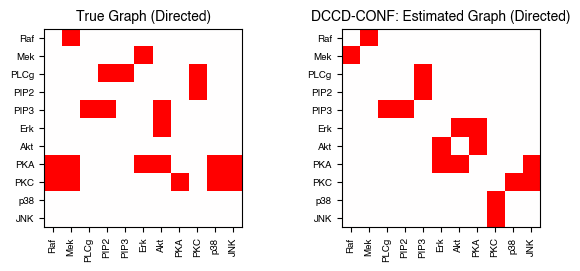

In [35]:
fig, axs = plt.subplots(1, 2)

plt.rcParams["font.family"] = "Helvetica"

d = len(names)

axs[0].imshow(np.abs(adj_mat) > 0, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_xticks(range(d))
axs[0].set_yticks(range(d))
axs[0].set_xticklabels(names, fontsize=7, rotation=90)
axs[0].set_yticklabels(names, fontsize=7)
axs[0].set_title("True Graph (Directed)", fontsize=10)

axs[1].imshow(g_x.get_w_adj().detach().cpu().numpy() > 0.5, cmap='bwr', vmin=-1, vmax=1)
axs[1].set_xticks(range(d))
axs[1].set_yticks(range(d))
axs[1].set_xticklabels(names, fontsize=7, rotation=90)
_ = axs[1].set_yticklabels(names, fontsize=7)
axs[1].set_title("DCCD-CONF: Estimated Graph (Directed)", fontsize=10)

fig.subplots_adjust(wspace=0.5)

fig.savefig("../results/sachs-adj-mat.pdf", bbox_inches="tight")


In [39]:
shd, _ = compute_shd(np.abs(adj_mat) > 0, g_x.get_w_adj().detach().cpu().numpy() > 0.5)

print(f"SHD = {int(shd)}")

SHD = 18
